In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
import os, re, csv, math, codecs

stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

Using TensorFlow backend.


In [2]:
# load embedding
# takes about 2 minutes to load
embeddings_index = {}
f = codecs.open('wiki-news-300d-1M-subword.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

999995it [01:32, 10835.77it/s]

found 999995 word vectors


# undersampling

In [3]:
#load data
#df = pd.read_pickle('tweets_sentiment_cleaned.pkl')
#df = pd.read_csv('../5153 Applied ML Project - General/Code/kaggleTweets_cleaned_all_dupl_withSW.csv')
df = pd.read_csv('../5153 Applied ML Project - General/Code/kaggleTweets_cleaned_undersamplig_dupl_Stopwords.csv')
#df = df.drop_duplicates('message',keep='first')
df.shape

(15036, 15)

In [4]:
X = df.message
y = df.sentiment.values
num_classes = len(np.unique(y))

In [50]:
y

array([-1,  1,  1, ...,  2,  0,  1], dtype=int64)

In [49]:
y_oh

array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [5]:
max_num_words = 100000
max_seq_len = 40
embed_dim=300
y_oh = keras.utils.to_categorical(y,num_classes)
def process_tweet_input_into_CNN_inputs(X):
    #raw_docs = X.tolist()
    raw_docs = X

    processed_docs = []
    for doc in tqdm(raw_docs):
        tokens = RegexpTokenizer(r'\w+').tokenize(doc)
        #filtered = [word for word in tokens if word not in stop_words]
        processed_docs.append(" ".join(tokens))

    tokenizer = Tokenizer(num_words=max_num_words, lower=True, char_level=False)
    tokenizer.fit_on_texts(processed_docs)

    word_seq = tokenizer.texts_to_sequences(processed_docs)
    word_index = tokenizer.word_index
    print("dictionary size: ", len(word_index))

    #pad sequences
    word_seq = sequence.pad_sequences(word_seq, maxlen=max_seq_len)
    return word_seq,word_index

word_seq,word_index = process_tweet_input_into_CNN_inputs(X)

100%|████████████████████████████████████████████████████████████████████████| 15036/15036 [00:00<00:00, 140897.44it/s]


dictionary size:  23967


In [6]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(max_num_words, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 9457


In [7]:
print("sample words not found: ", np.random.choice(words_not_found, 10))

sample words not found:  ['makeinindia' 'milankovitch' 'stephmthomas' 'samncypert' 'propney'
 'quickl' 'smdh' 'welfareworks' 'worldgovsummit' 'ericliptonnyt']


In [8]:
#define custom f1-score metric
#because keras doesn't have F1-score built in as a metric
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# model tuning

In [9]:
num_filters=100
kernel1=7
kernel2=7
weight_decay = 0.01
def get_model():#kernel1,kernel2,num_filters):
    model = Sequential()
    model.add(Embedding(nb_words, embed_dim,
              weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
    model.add(Conv1D(num_filters, kernel_size=kernel1, activation='relu', padding='same'))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(num_filters, kernel_size=kernel2, activation='relu', padding='same'))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Dense(4, activation='sigmoid'))  #multi-label (k-hot encoding)

    adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy',f1_m])
    #model.summary()
    
    return model

In [10]:
from sklearn.model_selection import *
from keras.wrappers.scikit_learn import *

word_seq_train, word_seq_test, y_train_oh, y_test_oh = train_test_split(word_seq,y_oh,test_size=0.2,random_state=10,stratify=y)
length = word_seq_train.shape[0]
model = KerasClassifier(build_fn=get_model)

#param_grid = dict(kernel1=[2,3,5],kernel2=[5],num_filters=[100])
param_grid = dict(batch_size=[2])
grid = GridSearchCV(estimator=model,param_grid=param_grid,n_jobs=1,cv=3)

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=1)
callbacks_list = [early_stopping]
grid_result = grid.fit(word_seq_train, y_train_oh, #batch_size=batch_size, epochs=num_epochs, 
                     callbacks=callbacks_list, 
                     validation_data=(word_seq_test, y_test_oh),
                     verbose=0)
    

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

10725/10725 [==============================] - 9s 861us/step


In [11]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
grid_result.best_params    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.816931 using {'batch_size': 2}
0.816931 (0.009359) with: {'batch_size': 2}


# rerunning with best params to get 5fold F1score

In [9]:
num_filters=200
kernel1=7
kernel2=7
weight_decay = 0.01
batch_size=128
def get_model():
    model = Sequential()
    model.add(Embedding(nb_words, embed_dim,
              weights=[embedding_matrix], input_length=max_seq_len, trainable=True))
    model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Dense(4, activation='sigmoid'))  #multi-label (k-hot encoding)

    adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy',f1_m])
    #model.summary()
    
    return model

In [10]:
N_SPLITS = 5
KFOLD = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=123)

def get_train_test_idx(fold_no, y):
    '''
    Get train test indices based on fold_no.
    fold_no is 0-index (i.e. 0,1,2,3,4)
    '''
    assert fold_no < N_SPLITS and fold_no >= 0, 'invalid fold number'
    
    for fold, (train_id, val_id) in enumerate(KFOLD.split(y, y)):
        if fold == fold_no:
            break
            
    return train_id, val_id

In [11]:
# 5fold model training
def run_fold(fold_no):
    
    train_idx, test_idx = get_train_test_idx(fold_no,y)
    word_seq_train = word_seq[train_idx]
    word_seq_test = word_seq[test_idx]
    y_train_oh = y_oh[train_idx]
    y_test_oh = y_oh[test_idx] 
    
    model = get_model()
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, verbose=1)
    callbacks_list = [early_stopping]
    history = model.fit(word_seq_train, y_train_oh, 
                     batch_size=batch_size, epochs=4, 
                     callbacks=callbacks_list, 
                     validation_data=(word_seq_test, y_test_oh),
                     verbose=0)

    fig, ax = plt.subplots(1,2, figsize=(14,4))
    ax[0].plot(history.history['accuracy'], label='Train Acc')
    ax[0].plot(history.history['val_accuracy'], label='Val Acc')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    ax[1].plot(history.history['f1_m'], label='Train F1')
    ax[1].plot(history.history['val_f1_m'], label='Val F1')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('F1 Score')
    ax[1].legend()

    fig.suptitle(f'Fold {fold_no+1} Training History')
    plt.show()

    del(model)
    
    return history.history['val_accuracy'][-1] , history.history['val_f1_m'][-1]

Running Fold 1
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



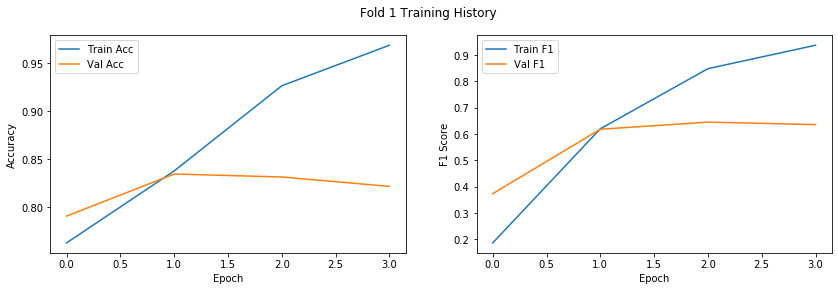

Running Fold 2


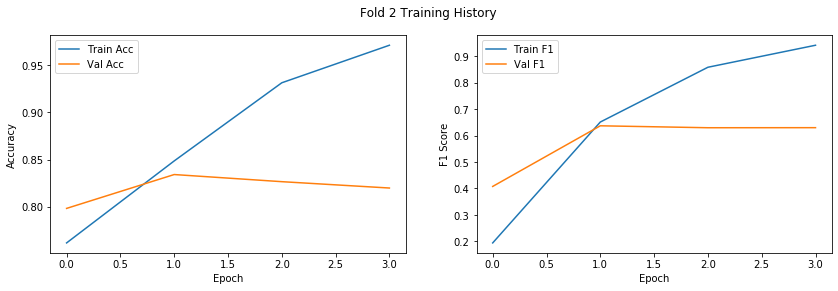

Running Fold 3


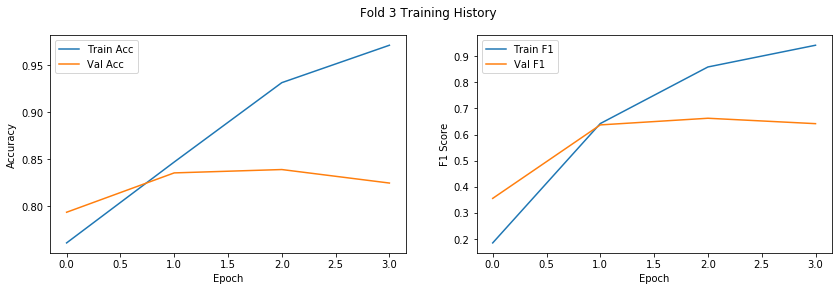

Running Fold 4


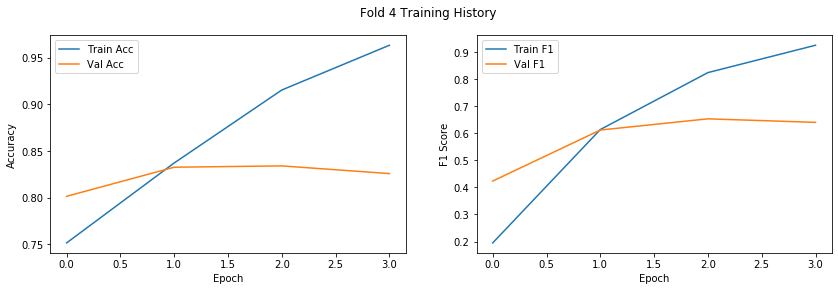

Running Fold 5


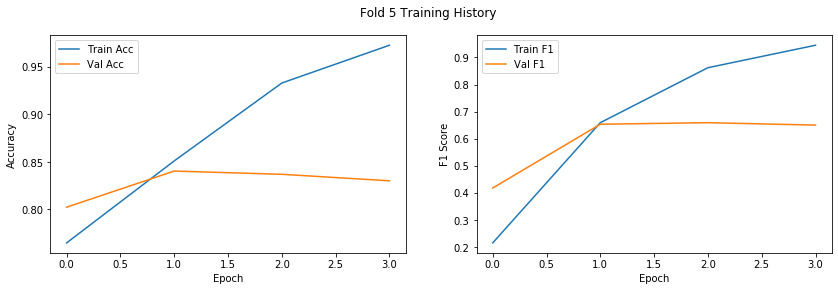

[[0.63543499]
 [0.63008416]
 [0.64182955]
 [0.64052582]
 [0.65003902]]


In [12]:
f1 = np.zeros((5,1))
acc = np.zeros((5,1))

for i in range(5):
    print(f'Running Fold {i + 1}')
    acc[i],f1[i] = run_fold(i)
    
print(f1)

In [14]:
print(f1.mean())
print(acc.mean())

0.6395827054977417
0.8243550658226013


# without resampling

In [15]:
#load data
#df = pd.read_pickle('tweets_sentiment_cleaned.pkl')
df = pd.read_csv('../5153 Applied ML Project - General/Code/kaggleTweets_cleaned_all_dupl_withSW.csv')
#df = pd.read_csv('../5153 Applied ML Project - General/Code/kaggleTweets_cleaned_undersamplig_dupl_Stopwords.csv')
#df = df.drop_duplicates('message',keep='first')
df.shape

(40219, 8)

In [16]:
X = df.message
y = df.sentiment.values
num_classes = len(np.unique(y))

In [17]:
max_num_words = 100000
max_seq_len = 40
embed_dim=300
y_oh = keras.utils.to_categorical(y,num_classes)
def process_tweet_input_into_CNN_inputs(X):
    #raw_docs = X.tolist()
    raw_docs = X

    processed_docs = []
    for doc in tqdm(raw_docs):
        tokens = RegexpTokenizer(r'\w+').tokenize(doc)
        #filtered = [word for word in tokens if word not in stop_words]
        processed_docs.append(" ".join(tokens))

    tokenizer = Tokenizer(num_words=max_num_words, lower=True, char_level=False)
    tokenizer.fit_on_texts(processed_docs)

    word_seq = tokenizer.texts_to_sequences(processed_docs)
    word_index = tokenizer.word_index
    print("dictionary size: ", len(word_index))

    #pad sequences
    word_seq = sequence.pad_sequences(word_seq, maxlen=max_seq_len)
    return word_seq,word_index

word_seq,word_index = process_tweet_input_into_CNN_inputs(X)

100%|████████████████████████████████████████████████████████████████████████| 40219/40219 [00:00<00:00, 141002.71it/s]


dictionary size:  43639


In [18]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(max_num_words, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 21839


In [19]:
print("sample words not found: ", np.random.choice(words_not_found, 10))

sample words not found:  ['richlowry' 'inversedotcom' 'stephenkbannon' 'davidjo' 'benjealous'
 'paceturf' 'liamly' 'gvnmts' 'treefree' 'revsallybingham']


In [20]:
#define custom f1-score metric
#because keras doesn't have F1-score built in as a metric
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [21]:
num_filters=200
kernel1=7
kernel2=7
weight_decay = 0.01
batch_size=128
def get_model():
    model = Sequential()
    model.add(Embedding(nb_words, embed_dim,
              weights=[embedding_matrix], input_length=max_seq_len, trainable=True))
    model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Dense(4, activation='sigmoid'))  #multi-label (k-hot encoding)

    adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy',f1_m])
    #model.summary()
    
    return model

In [22]:
N_SPLITS = 5
KFOLD = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=123)

def get_train_test_idx(fold_no, y):
    '''
    Get train test indices based on fold_no.
    fold_no is 0-index (i.e. 0,1,2,3,4)
    '''
    assert fold_no < N_SPLITS and fold_no >= 0, 'invalid fold number'
    
    for fold, (train_id, val_id) in enumerate(KFOLD.split(y, y)):
        if fold == fold_no:
            break
            
    return train_id, val_id

In [23]:
# 5fold model training
def run_fold(fold_no):
    
    train_idx, test_idx = get_train_test_idx(fold_no,y)
    word_seq_train = word_seq[train_idx]
    word_seq_test = word_seq[test_idx]
    y_train_oh = y_oh[train_idx]
    y_test_oh = y_oh[test_idx] 
    
    model = get_model()
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, verbose=1)
    callbacks_list = [early_stopping]
    history = model.fit(word_seq_train, y_train_oh, 
                     batch_size=batch_size, epochs=4, 
                     callbacks=callbacks_list, 
                     validation_data=(word_seq_test, y_test_oh),
                     verbose=0)

    fig, ax = plt.subplots(1,2, figsize=(14,4))
    ax[0].plot(history.history['accuracy'], label='Train Acc')
    ax[0].plot(history.history['val_accuracy'], label='Val Acc')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    ax[1].plot(history.history['f1_m'], label='Train F1')
    ax[1].plot(history.history['val_f1_m'], label='Val F1')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('F1 Score')
    ax[1].legend()

    fig.suptitle(f'Fold {fold_no+1} Training History')
    plt.show()

    del(model)
    
    return history.history['val_accuracy'][-1] , history.history['val_f1_m'][-1]

Running Fold 1


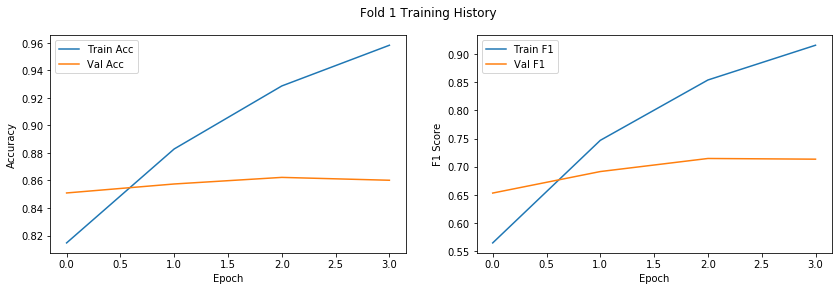

Running Fold 2


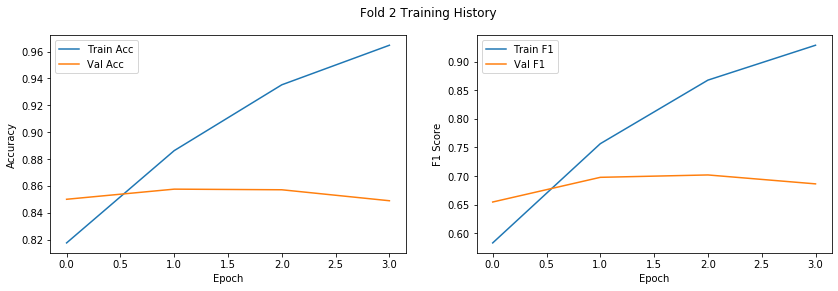

Running Fold 3


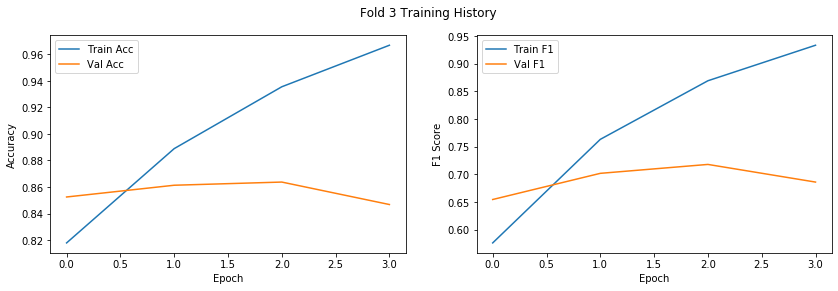

Running Fold 4


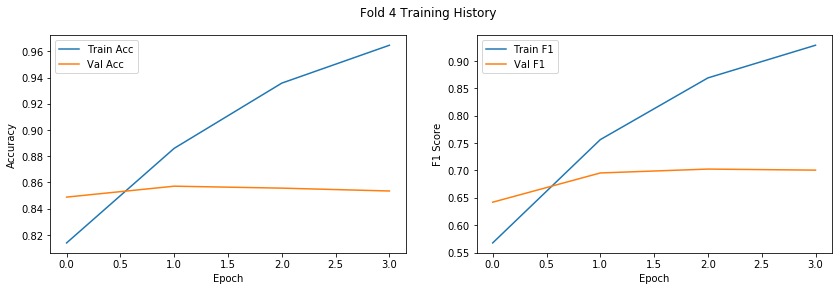

Running Fold 5


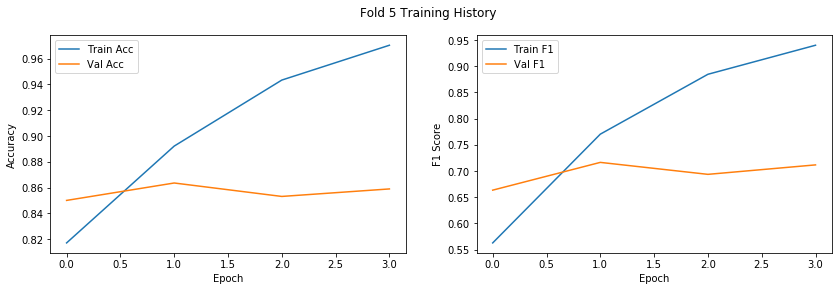

[[0.71337336]
 [0.68639952]
 [0.68599391]
 [0.7006312 ]
 [0.71165293]]


In [24]:
f1 = np.zeros((5,1))
acc = np.zeros((5,1))

for i in range(5):
    print(f'Running Fold {i + 1}')
    acc[i],f1[i] = run_fold(i)
    
print(f1)

In [25]:
print(f1.mean())
print(acc.mean())

0.6996101856231689
0.8536700367927551


# predict US twitter

In [29]:
import pandas as pd
import numpy as np
import scipy as sp
import re
import time

from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
#from wordcloud import WordCloud, STOPWORDS
from nltk import word_tokenize
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from langdetect import detect_langs

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
import string

import matplotlib.pyplot as plt
import seaborn as sns

#if not sys.warnoptions:
       # import warnings
        #suppress warning messages (those with peach background)
        #warnings.simplefilter("ignore")

In [30]:
us=pd.read_csv('twitter_us.csv')
us.head()

,US,id,permalink,username,to,text,date,replies,retweets,favorites,mentions,hashtags,geo
0,Alabama,1231749999446437888,https://twitter.com/kcazvegas/status/123174999...,kcazvegas,NaN,Watch: Woman Removed For Asking Bernie Sanders...,2020-02-24 01:17:39,0,0,0,@BernieSanders,NaN,NaN
1,Alabama,1231746735405486082,https://twitter.com/simplyadornedal/status/123...,simplyadornedal,NaN,"<a href=""/JoeBiden"" class=""twitter-atreply pre...",2020-02-24 01:04:41,0,0,0,@JoeBiden,NaN,NaN
2,Arizona,1231736482345312256,https://twitter.com/JehannDeb/status/123173648...,JehannDeb,NaN,(short) Video of AOC visiting Standing Rock In...,2020-02-24 00:23:56,0,0,0,NaN,NaN,NaN
3,Arkansas,1231737869649285121,https://twitter.com/johnettesnuggs/status/1231...,johnettesnuggs,TheUSASingers,I live in rural Arkansas and this article says...,2020-02-24 00:29:27,0,0,1,NaN,NaN,NaN
4,California,1231754178634010631,https://twitter.com/Catherinetheno1/status/123...,Catherinetheno1,czechered1,"I consider these ""tax cuts"" as more a bribe to...",2020-02-24 01:34:15,0,0,0,NaN,NaN,NaN


In [32]:
us=us.drop_duplicates('text',keep='first')
us=us.reset_index()

In [36]:
#text processing steps definition

def html_tag_remover(text):
    soup = BeautifulSoup(text)
    text_out = soup.get_text()
    return text_out

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def stopwords_remove(text):
    STOPWORDS = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

def CleanMessage(us):
    us['text'] = us['text'].apply(lambda x:html_tag_remover(x))
   # us['text']=us['text'].apply(lambda x : remove_html(x)) # Remove HTML
    us['text']=us['text'].apply(lambda x : remove_URL(x)) 
    
    us['text'] = us['text'].str.lower()
    us['text'] = us['text'].str.replace(r'[^a-z]+',' ')
    us['text'] = us['text'].str.replace(r'[\s+]', ' ')

    us['text'] = us['text'].str.replace('leonardo','dicaprio')
    us['text'] = us['text'].str.replace('leodicaprio','dicaprio')
    us['text'] = us['text'].str.replace('leo','dicaprio')
    #us['text'] = us['text'].apply(stopwords_remove) #stopwords
    print('The messages have been cleaned')
    #return us           

def Lemma(us):
    us['message_toc']=[word_tokenize(text) for text in us['text']]
    WNLemmatizer=WordNetLemmatizer()
    us['message_lem']=[[WNLemmatizer.lemmatize(word) for word in token] for token in us['message_toc']]
    us['message_len_str'] = us.message_lem.astype(str)  
    print('The messages have been tokenized and lemmatized')
    return us

def WorldCloudBuilt(us):
    text=us['text'].str.cat()
    my_stopwords=set(STOPWORDS)
    my_stopwords.update(['many','will','via','thing','one','say','rt','https rt'])
    text=WordCloud(background_color="white",max_words=100, stopwords=my_stopwords).generate(text)
    
    plt.figure(figsize=(20,10))
    plt.imshow(text, interpolation='bilinear')
    plt.axis('off')
    plt.show()   

# text processing  for Kaggle dataset
CleanMessage(us)
Lemma(us)
print('\nFist 1000 strings after cleaning: ')
print(us['text'].str.cat()[:1000])
#WorldCloudBuilt(us)

The messages have been cleaned
The messages have been tokenized and lemmatized

Fist 1000 strings after cleaning: 
watch woman removed for asking bernie sanders to give up jet travel while talking climate change newswars berniesanders your a communist  joebiden should say he would appoint someone to deal with climate change within administration talk about jobs that can be created from green short video of aoc visiting standing rock indian reservation and becoming more oriented towards where she is today as a voice to be heard as expert on climate change and the green earth i live in rural arkansas and this article says a lot people who live in rural areas get ignored most of the time but we deserve better the nation deserves better the world deserves better pay attention to climate change i consider these tax cuts as more a bribe to get the to be complicit about him getting reelected they will lose all of these tax cuts and their precious billionaire funded money bags lobbyist cash co

In [38]:
#other than english language detection

languages=[]
rows_error=[]
for row in range(len(us)):
    try:
        languages.append(detect_langs(us.loc[row,'text']))
    except:
        language = "error"
        rows_error.append(row)
            
str(languages[0]).split(':')
str(languages[0]).split(':')[0]
str(languages[0]).split(':')[0][1:]
languages=[str(lang).split(':')[0][1:] for lang in languages]
    
us=us.drop(rows_error,axis=0)
    
us['language']=languages
us = us[us.language =='en']
print('The messages in other than english languagge have been removed. The dataset has',us.shape[0],'rows.')

The messages in other than english languagge have been removed. The dataset has 54899 rows.


# retraining CNN model with full kaggle dataset

In [39]:
model = get_model()
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, verbose=1)
callbacks_list = [early_stopping]
history = model.fit(word_seq, y_oh, 
                 batch_size=batch_size, epochs=4, 
                 callbacks=callbacks_list, 
                 #validation_data=(word_seq_test, y_test_oh),
                 verbose=0)

C:\Users\Calvin\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,f1_m
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


In [51]:
word_seq_test = process_tweet_input_into_CNN_inputs(us['text'])[0]
y_pred_oh = model.predict(word_seq_test)
y_pred = 2-np.argmax(y_pred_oh,axis=1) #one hot decoding
print(y_pred_oh)


100%|████████████████████████████████████████████████████████████████████████| 54899/54899 [00:00<00:00, 101748.56it/s]


dictionary size:  65578
[[2.6544446e-01 7.1806037e-01 1.7943114e-02 1.9704401e-03]
 [3.0876648e-01 1.7415008e-01 5.6416506e-01 4.5277089e-02]
 [5.4019749e-02 9.5029068e-01 8.5547566e-04 1.2576580e-05]
 ...
 [7.6405251e-01 2.0942789e-01 6.4755350e-02 5.9693962e-02]
 [1.8987197e-01 8.9530003e-01 1.3023615e-05 3.7920475e-04]
 [7.0632756e-02 3.4884572e-02 1.7266834e-01 5.2029192e-03]]


In [53]:
us['CNN_pred'] = y_pred
us.to_csv('CNN_predictions_on_US_tweets.csv',index=False)